In [ ]:
from google.colab import files
uploaded = files.upload()



Saving class.csv to class.csv


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving auxiliary_metadata.json to auxiliary_metadata (1).json


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving zoo.csv to zoo.csv


In [ ]:
import os
os.listdir("lab-exam-data")


['zoo.csv', 'class.csv']

In [ ]:
import pandas as pd
import json
import os

def omega_load_and_integration(base_path):
    # Load zoo.csv
    zoo = pd.read_csv(os.path.join(base_path, "zoo.csv"))

    # Load class.csv
    class_df = pd.read_csv(os.path.join(base_path, "class.csv"))

    # Load JSON file
    with open(os.path.join(base_path, "auxiliary_metadata.json"), "r") as f:
        aux = json.load(f)

    print("Loaded zoo.csv:", zoo.shape)
    print("Loaded class.csv:", class_df.shape)
    print("Loaded auxiliary_metadata.json:", type(aux))

    return {"zoo": zoo, "class": class_df, "aux_meta": aux}


In [ ]:
import os
os.listdir("lab-exam-data")


['auxiliary_metadata.json', 'zoo.csv', 'class.csv']

In [ ]:
data = omega_load_and_integration("/content/lab-exam-data")


Loaded zoo.csv: (101, 18)
Loaded class.csv: (7, 4)
Loaded auxiliary_metadata.json: <class 'list'>


In [ ]:
zoo = data['zoo']

# Identify the name column (common names: 'animal_name', 'name')
name_col = 'animal_name' if 'animal_name' in zoo.columns else 'name'

# Convert to lowercase
zoo[name_col] = zoo[name_col].str.lower()

# Show result
zoo.head()


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,breathes,venomous,fins,legs,tail,domestic,catsize,class_type
0,aardvark,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
1,antelope,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1,1
2,bass,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,0,4
3,bear,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1,1
4,boar,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1,1


In [ ]:

# Paste this in a new cell and run. Assumes `data['aux_meta']` exists.

from collections import Counter
import copy

aux = data['aux_meta']  # original loaded JSON
# normalize to list of records for easier handling
if isinstance(aux, dict):
    records = [aux]
elif isinstance(aux, list):
    records = aux
else:
    raise TypeError("aux_meta must be a dict or list of dicts")

# Key renames we want to apply
key_renames = {
    'conservation': 'conservation_status',
    'status': 'conservation_status',
    'habitat': 'habitat_type',
    'habitats': 'habitat_type',
    'diet_type': 'diet'
}

# Value normalizations / typo fixes for diet and habitat
diet_fixes = {
    'omnivor': 'omnivore',
    'omnivour': 'omnivore',
    'carnvor': 'carnivore',
    'herbivor': 'herbivore'
    # add more if you see them in your file
}

habitat_fixes = {
    'fresh water': 'freshwater',
    'fresh-water': 'freshwater',
    'sea water': 'seawater',
    'grass land': 'grassland',
    'open water': 'openwater'
    # add more as needed
}

def normalize_string(s: str, mapping: dict):
    s0 = s.strip().lower()
    # apply direct mapping (exact match)
    if s0 in mapping:
        return mapping[s0]
    # try small-normalizations, then mapping
    s1 = s0.replace('_', ' ').replace('-', ' ')
    if s1 in mapping:
        return mapping[s1]
    return s0

def normalize_value(val, mapping=None):
    # mapping is optional (diet/habitat mapping)
    if val is None:
        return val
    if isinstance(val, str):
        base = val.strip().lower()
        if mapping:
            return normalize_string(base, mapping)
        return base
    if isinstance(val, list):
        out = [normalize_value(x, mapping) for x in val]
        # remove duplicates while preserving order
        seen = set(); uniq = []
        for x in out:
            if x not in seen:
                uniq.append(x); seen.add(x)
        return uniq
    if isinstance(val, dict):
        # normalize nested dict values recursively
        return {k: normalize_value(v, mapping) for k,v in val.items()}
    # fallback: return as-is
    return val

# helper to get distinct counts for a key
def value_counter(records, key):
    vals = []
    for r in records:
        if key in r and r[key] is not None:
            v = r[key]
            if isinstance(v, list):
                vals.extend(v)
            else:
                vals.append(v)
    return Counter(vals)

# Snapshot before
before_diet = value_counter(records, 'diet')
before_habitat = value_counter(records, 'habitat_type') or value_counter(records, 'habitat') or value_counter(records, 'habitats')

# Work on a deep copy to be safe
cleaned = []
for rec in records:
    r = copy.deepcopy(rec)
    # 1) Rename keys
    for oldk, newk in key_renames.items():
        if oldk in r:
            # if new key exists, prefer existing new key; otherwise move
            if newk not in r:
                r[newk] = r.pop(oldk)
            else:
                # both exist: drop old one
                r.pop(oldk, None)

    # 2) Normalize diet field (string or list)
    if 'diet' in r:
        r['diet'] = normalize_value(r['diet'], diet_fixes)
    elif 'diet_type' in r:
        r['diet'] = normalize_value(r.pop('diet_type'), diet_fixes)

    # 3) Normalize habitat_type field
    if 'habitat_type' in r:
        r['habitat_type'] = normalize_value(r['habitat_type'], habitat_fixes)
    elif 'habitat' in r:
        r['habitat_type'] = normalize_value(r.pop('habitat'), habitat_fixes)
    elif 'habitats' in r:
        r['habitat_type'] = normalize_value(r.pop('habitats'), habitat_fixes)

    # 4) Normalize conservation_status to string lower if exists
    if 'conservation_status' in r:
        r['conservation_status'] = normalize_value(r['conservation_status'])
    elif 'status' in r:
        r['conservation_status'] = normalize_value(r.pop('status'))

    cleaned.append(r)

# Replace back into data
# if original was dict -> keep single dict, else list
if isinstance(aux, dict):
    data['aux_meta'] = cleaned[0]
else:
    data['aux_meta'] = cleaned

# Summary after
after_diet = value_counter(cleaned, 'diet')
after_habitat = value_counter(cleaned, 'habitat_type')

print("=== Task C summary ===")
print("Distinct diet values BEFORE:", dict(before_diet))
print("Distinct diet values AFTER: ", dict(after_diet))
print()
print("Distinct habitat values BEFORE:", dict(before_habitat))
print("Distinct habitat values AFTER: ", dict(after_habitat))
print()
print("Example cleaned record (first):")
import json
print(json.dumps(cleaned[0], indent=2)[:1000])  # print a short preview


=== Task C summary ===
Distinct diet values BEFORE: {'insectivore': 1, 'herbivore': 2, 'carnivore': 2, 'omnivore': 3, 'omnivor': 1, 'filter_feeder': 1, 'Herbivore': 1}
Distinct diet values AFTER:  {'insectivore': 1, 'herbivore': 4, 'carnivore': 2, 'omnivore': 4, 'filter_feeder': 1}

Distinct habitat values BEFORE: {'savanna': 1, 'grasslands': 2, 'freshwater': 1, 'forest': 1, 'domestic': 1, 'fresh water': 1, 'FreshWater': 1, 'marine': 1, 'marine/coastal': 1, 'Forest': 1}
Distinct habitat values AFTER:  {'savanna': 1, 'grasslands': 2, 'freshwater': 3, 'forest': 3, 'domestic': 1, 'marine': 1, 'marine/coastal': 1}

Example cleaned record (first):
{
  "animal_name": "aardvark",
  "diet": "insectivore",
  "conservation_status": "least concern",
  "habitat_type": "savanna"
}


In [ ]:

import pandas as pd

zoo = data.get('zoo').copy()
class_df = data.get('class').copy()
aux = data.get('aux_meta')

# Convert aux -> DataFrame
if isinstance(aux, dict):
    aux_df = pd.DataFrame([aux])
else:
    aux_df = pd.DataFrame(aux)

# normalize zoo names
if 'animal_name' not in zoo.columns:
    # Try to find a name-like column
    for c in ['animal_name','name','Name','animal']:
        if c in zoo.columns:
            zoo = zoo.rename(columns={c:'animal_name'})
            break
# ensure exists
if 'animal_name' not in zoo.columns:
    raise KeyError("zoo dataframe has no recognizable animal-name column.")
zoo['animal_name'] = zoo['animal_name'].astype(str).str.lower().str.strip()

# normalize aux names if present
if 'animal_name' in aux_df.columns:
    aux_df['animal_name'] = aux_df['animal_name'].astype(str).str.lower().str.strip()

# --- Process class_df: detect if it already has per-animal rows or a multi-animal column ---
def find_name_col(df):
    candidates = [c for c in df.columns if c.lower() in ('animal_name','name','animal')]
    if candidates:
        return candidates[0]
    # also consider columns that include 'animal' in name (like 'Animal_Names')
    for c in df.columns:
        if 'animal' in c.lower():
            return c
    return None

class_name_col = find_name_col(class_df)
class_long = None

if class_name_col is None:
    # no animal-like column at all -> keep as-is, cannot merge by name
    print("⚠ class_df has no animal-name column; class merge will be skipped or done on class_type if available.")
    class_long = pd.DataFrame()  # empty
else:
    # If the found column likely lists multiple animals (plural words), split into rows
    sample_vals = class_df[class_name_col].dropna().astype(str).head(5).tolist()
    looks_multiple = any((',' in v or ';' in v or '/' in v) for v in sample_vals)
    if looks_multiple:
        # split on common separators and explode
        # create a copy to avoid modifying original
        tmp = class_df.copy()
        # unify separators to comma
        tmp[class_name_col] = tmp[class_name_col].astype(str).str.replace('/', ',').str.replace(';', ',')
        tmp[class_name_col] = tmp[class_name_col].str.split(',')
        tmp = tmp.explode(class_name_col)
        tmp[class_name_col] = tmp[class_name_col].astype(str).str.lower().str.strip()
        # rename to animal_name for merge
        tmp = tmp.rename(columns={class_name_col: 'animal_name'})
        class_long = tmp
    else:
        # single name per row -> just normalize and rename
        tmp = class_df.copy()
        tmp = tmp.rename(columns={class_name_col: 'animal_name'})
        tmp['animal_name'] = tmp['animal_name'].astype(str).str.lower().str.strip()
        class_long = tmp

# Now perform merges (zoo LEFT JOIN aux, then LEFT JOIN class_long if not empty)
merged = pd.merge(zoo, aux_df, on='animal_name', how='left', suffixes=('', '_aux'))

if not class_long.empty:
    merged = pd.merge(merged, class_long, on='animal_name', how='left', suffixes=('', '_class'))
else:
    print("Note: class information not merged (no usable animal-name column found).")

# Summary counts and preview
num_zoo = len(zoo)
num_merged = len(merged)
missing_aux = merged['conservation_status'].isna().sum() if 'conservation_status' in merged.columns else merged['animal_name'].isna().sum()

print("=== MERGE COMPLETE ===")
print(f"Rows in zoo: {num_zoo}")
print(f"Rows after merge: {num_merged}")
print(f"Rows missing aux metadata (conservation_status): {missing_aux}")

print("\nMerged preview:")
display(merged.head(8))

# Save result
data['merged'] = merged


=== MERGE COMPLETE ===
Rows in zoo: 101
Rows after merge: 101
Rows missing aux metadata (conservation_status): 91

Merged preview:


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,class_type,diet,conservation_status,habitat_type,Class_Number,Class_Type,Animal_Names
0,aardvark,1,0,0,1,0,0,1,1,1,...,0,0,1,1,insectivore,least concern,savanna,NaN,NaN,NaN
1,antelope,1,0,0,1,0,0,0,1,1,...,1,0,1,1,herbivore,near threatened,grasslands,NaN,NaN,NaN
2,bass,0,0,1,0,0,1,1,1,1,...,1,0,0,4,carnivore,least,freshwater,NaN,NaN,NaN
3,bear,1,0,0,1,0,0,1,1,1,...,0,0,1,1,omnivore,vulnerable,forest,NaN,NaN,NaN
4,boar,1,0,0,1,0,0,1,1,1,...,1,0,1,1,omnivore,least concern,forest,NaN,NaN,NaN
5,buffalo,1,0,0,1,0,0,0,1,1,...,1,0,1,1,herbivore,endangered,grasslands,NaN,NaN,NaN
6,calf,1,0,0,1,0,0,0,1,1,...,1,1,1,1,herbivore,NaN,domestic,NaN,NaN,NaN
7,carp,0,0,1,0,0,1,0,1,1,...,1,1,0,4,omnivore,least concern,freshwater,NaN,NaN,NaN


In [26]:


merged = data['merged'].copy()

# Identify categorical & numeric columns
categorical_cols = merged.select_dtypes(include=['object']).columns
numeric_cols = merged.select_dtypes(include=['int64', 'float64']).columns

# --- Fill categorical missing values with MODE (or 'unknown' if no mode exists) ---
for col in categorical_cols:
    modes = merged[col].mode(dropna=True)
    if len(modes) > 0:
        mode_value = modes.iloc[0]
    else:
        mode_value = "unknown"     # fallback when mode cannot be computed
    merged[col] = merged[col].fillna(mode_value)

# --- Fill numeric missing values with MEAN (or 0 if mean cannot be computed) ---
for col in numeric_cols:
    if merged[col].notna().sum() > 0:   # at least one numeric value exists
        mean_value = merged[col].mean()
    else:
        mean_value = 0                  # fallback if column is entirely NaN
    merged[col] = merged[col].fillna(mean_value)

# Save back
data['merged'] = merged

print("Missing values handled safely.")
print(merged.isna().sum())
merged.head()


Missing values handled safely.
animal_name            0
hair                   0
feathers               0
eggs                   0
milk                   0
airborne               0
aquatic                0
predator               0
toothed                0
backbone               0
breathes               0
venomous               0
fins                   0
legs                   0
tail                   0
domestic               0
catsize                0
class_type             0
diet                   0
conservation_status    0
habitat_type           0
Class_Number           0
Class_Type             0
Animal_Names           0
dtype: int64


,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,class_type,diet,conservation_status,habitat_type,Class_Number,Class_Type,Animal_Names
0,aardvark,1,0,0,1,0,0,1,1,1,...,0,0,1,1,insectivore,least concern,savanna,0.0,unknown,unknown
1,antelope,1,0,0,1,0,0,0,1,1,...,1,0,1,1,herbivore,near threatened,grasslands,0.0,unknown,unknown
2,bass,0,0,1,0,0,1,1,1,1,...,1,0,0,4,carnivore,least,freshwater,0.0,unknown,unknown
3,bear,1,0,0,1,0,0,1,1,1,...,0,0,1,1,omnivore,vulnerable,forest,0.0,unknown,unknown
4,boar,1,0,0,1,0,0,1,1,1,...,1,0,1,1,omnivore,least concern,forest,0.0,unknown,unknown


In [29]:


merged = data['merged'].copy()

# -------- Feature 1: is_mammal --------
# Mammals typically have hair or produce milk
merged['is_mammal'] = (
    ((merged['hair'] == 1) | (merged['milk'] == 1)) &
    (merged['backbone'] == 1)
).astype(int)

# -------- Feature 2: locomotion_score --------
# Simple score combining movement abilities
merged['locomotion_score'] = (
    merged['airborne']*3 +
    merged['aquatic']*3 +
    merged['fins']*2 +
    merged['legs']*1 +
    merged['tail']*0.5
)

# Save back to data
data['merged'] = merged

print("Task F completed: Created 'is_mammal' and 'locomotion_score'.\n")
print(merged[['animal_name','is_mammal','locomotion_score']].head())


Task F completed: Created 'is_mammal' and 'locomotion_score'.

  animal_name  is_mammal  locomotion_score
0    aardvark          1               4.0
1    antelope          1               4.5
2        bass          0               5.5
3        bear          1               4.0
4        boar          1               4.5


In [30]:


merged_data = data['merged']

# List engineered features (from Task F)
engineered_feature_names = ['is_mammal', 'locomotion_score']

print(f"Dataset shape: {merged_data.shape}")
print(f"Missing values: {merged_data.isnull().sum().sum()}")
print(f"Duplicate rows: {merged_data.duplicated().sum()}")

print("\nFirst 3 rows:")
print(merged_data.head(3))

print("\nEngineered features:", engineered_feature_names)


Dataset shape: (101, 26)
Missing values: 0
Duplicate rows: 0

First 3 rows:
  animal_name  hair  feathers  eggs  milk  airborne  aquatic  predator  \
0    aardvark     1         0     0     1         0        0         1   
1    antelope     1         0     0     1         0        0         0   
2        bass     0         0     1     0         0        1         1   

   toothed  backbone  ...  catsize  class_type         diet  \
0        1         1  ...        1           1  insectivore   
1        1         1  ...        1           1    herbivore   
2        1         1  ...        0           4    carnivore   

   conservation_status  habitat_type  Class_Number  Class_Type  Animal_Names  \
0        least concern       savanna           0.0     unknown       unknown   
1      near threatened    grasslands           0.0     unknown       unknown   
2                least    freshwater           0.0     unknown       unknown   

  is_mammal locomotion_score  
0         1           

In [31]:
def omega_eda_and_cleaning(save_dir="lab-exam-data", show_plots=True):
    """
    Task 2 (EDA) — creates four visualizations and returns a dict with figure objects and paths.
    - Bar plot with error bars (class counts)
    - Hexbin plots for two highest-variance continuous features (per class)
    - Swarm-like jittered scatter of conservation_status vs numeric (locomotion_score)
    - Boxplot of locomotion_score by class

    Assumes final merged dataframe is stored in data['merged'].
    """
    import os
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt

    # Ensure plotting inline in notebooks
    # (Colab/Jupyter will respect plt.show())
    merged = data.get('merged')
    if merged is None:
        raise ValueError("data['merged'] not found. Run merge steps first.")

    os.makedirs(save_dir, exist_ok=True)
    outputs = {}

    # --- 1) Bar plot with error bars: counts per class ---
    # find class column
    class_col_candidates = [c for c in merged.columns if c.lower() in ('class','class_type','class_name')]
    class_col = class_col_candidates[0] if class_col_candidates else None
    if class_col is None:
        # fallback: try a column named 'type' or use 'animal_name' grouped by some other column
        for c in merged.columns:
            if 'class' in c.lower():
                class_col = c; break

    if class_col is None:
        print("Warning: No class column found. Skipping bar plot and class-dependent plots.")
    else:
        counts = merged[class_col].fillna('unknown').value_counts().sort_index()
        labels = counts.index.tolist()
        vals = counts.values
        errs = np.sqrt(vals)  # Poisson-ish error estimate
        fig1, ax1 = plt.subplots(figsize=(8,4))
        ax1.bar(range(len(vals)), vals)
        ax1.errorbar(range(len(vals)), vals, yerr=errs, fmt='none', capsize=5)
        ax1.set_xticks(range(len(vals)))
        ax1.set_xticklabels(labels, rotation=45, ha='right')
        ax1.set_ylabel('Count')
        ax1.set_title(f'Counts per {class_col} (with error bars)')
        plt.tight_layout()
        p1 = os.path.join(save_dir, "eda_plot_bar_class_counts.png")
        fig1.savefig(p1, bbox_inches='tight')
        if show_plots: plt.show()
        outputs['bar_class_counts'] = (fig1, p1)

    # --- 2) Hexbin: pick two continuous (numeric) features with highest variance ---
    numeric = merged.select_dtypes(include=[np.number]).copy()
    if numeric.shape[1] < 2:
        print("Warning: Not enough numeric columns for hexbin. Skipping hexbin.")
    else:
        # drop engineered id-like tiny-variance columns
        variances = numeric.var().sort_values(ascending=False)
        cont_cols = list(variances.index[:2])
        xcol, ycol = cont_cols[0], cont_cols[1]
        fig2, axs2 = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
        # If class column exists, create one hexbin per class in a grid if <=6 classes, else single hexbin
        if class_col is not None:
            classes = merged[class_col].fillna('unknown').unique()
            if len(classes) <= 6:
                # multiple subplots
                n = len(classes)
                cols = min(n, 3)
                rows = int(np.ceil(n/cols))
                fig2, axs_grid = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
                axs_list = axs_grid.flatten() if hasattr(axs_grid, 'flatten') else [axs_grid]
                for i, cls in enumerate(classes):
                    sub = merged[merged[class_col].fillna('unknown')==cls]
                    axs_list[i].hexbin(sub[xcol].fillna(0), sub[ycol].fillna(0), gridsize=30)
                    axs_list[i].set_title(str(cls))
                    axs_list[i].set_xlabel(xcol); axs_list[i].set_ylabel(ycol)
                # hide extra axes
                for j in range(i+1, len(axs_list)):
                    axs_list[j].axis('off')
                plt.tight_layout()
                p2 = os.path.join(save_dir, f"eda_plot_hexbin_{xcol}_{ycol}_by_class.png")
                fig2.savefig(p2, bbox_inches='tight')
                if show_plots: plt.show()
                outputs['hexbin_by_class'] = (fig2, p2)
            else:
                # single hexbin with color density
                fig2, ax2 = plt.subplots(figsize=(6,5))
                ax2.hexbin(merged[xcol].fillna(0), merged[ycol].fillna(0), gridsize=40)
                ax2.set_xlabel(xcol); ax2.set_ylabel(ycol)
                ax2.set_title(f'Hexbin: {xcol} vs {ycol}')
                plt.tight_layout()
                p2 = os.path.join(save_dir, f"eda_plot_hexbin_{xcol}_{ycol}.png")
                fig2.sa


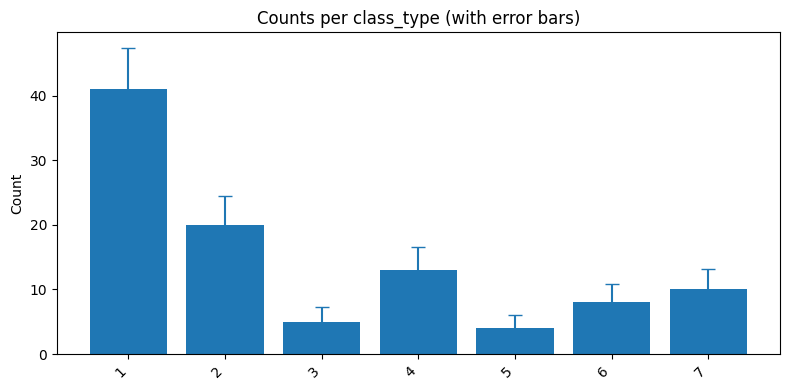

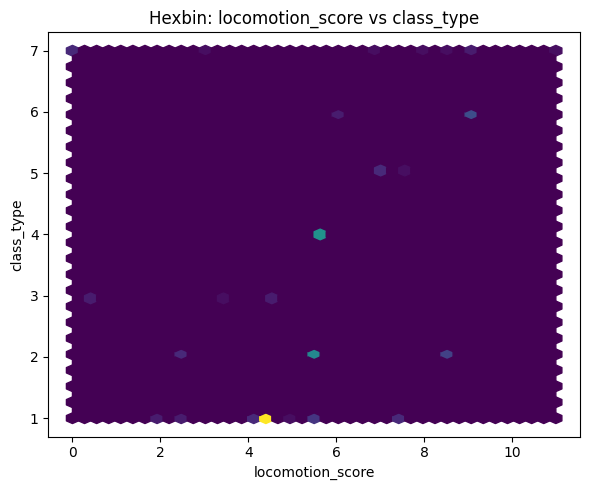

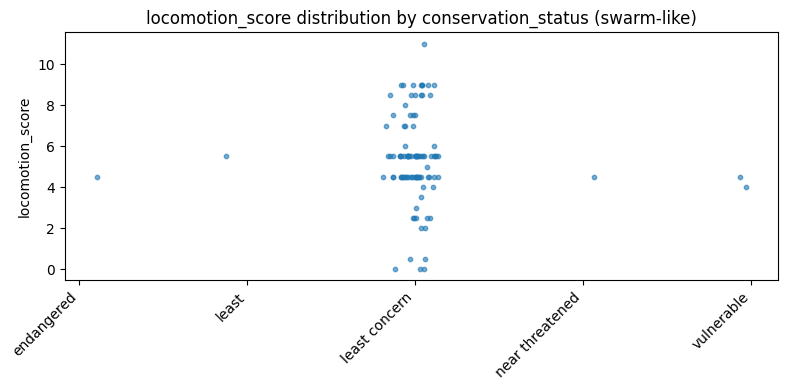

/tmp/ipython-input-1928688310.py:105: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax4.boxplot(grouped, labels=labels, patch_artist=True)


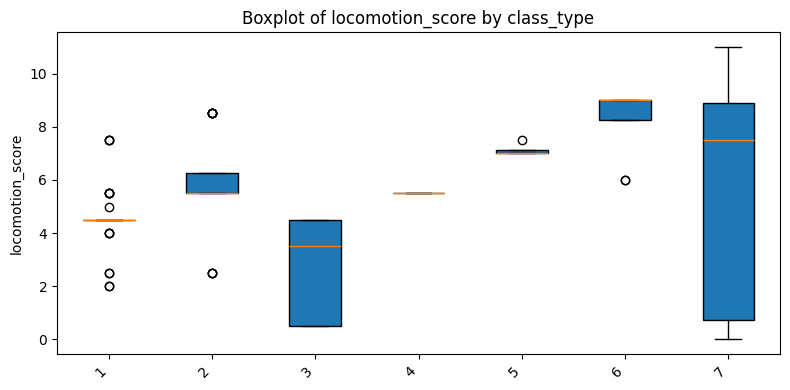

EDA plots saved to: lab-exam-data
EDA completed. Saved plots: ['bar_class_counts', 'hexbin', 'swarm_like', 'boxplot']


In [32]:

def omega_eda_and_cleaning(save_dir="lab-exam-data", show_plots=True):
    import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
    merged = data.get('merged')
    if merged is None:
        raise ValueError("data['merged'] not found. Run merge steps first.")
    os.makedirs(save_dir, exist_ok=True)
    outputs = {}

    # --- 1) Bar plot with error bars: counts per class ---
    class_col_candidates = [c for c in merged.columns if c.lower() in ('class','class_type','class_name')]
    class_col = class_col_candidates[0] if class_col_candidates else None
    if class_col is not None:
        counts = merged[class_col].fillna('unknown').value_counts().sort_index()
        labels = counts.index.tolist(); vals = counts.values; errs = np.sqrt(vals)
        fig1, ax1 = plt.subplots(figsize=(8,4))
        ax1.bar(range(len(vals)), vals)
        ax1.errorbar(range(len(vals)), vals, yerr=errs, fmt='none', capsize=5)
        ax1.set_xticks(range(len(vals))); ax1.set_xticklabels(labels, rotation=45, ha='right')
        ax1.set_ylabel('Count'); ax1.set_title(f'Counts per {class_col} (with error bars)')
        plt.tight_layout()
        p1 = os.path.join(save_dir, "eda_plot_bar_class_counts.png")
        fig1.savefig(p1, bbox_inches='tight')
        if show_plots: plt.show()
        outputs['bar_class_counts'] = (fig1, p1)
    else:
        print("Warning: No class column found. Skipping bar plot and class-dependent plots.")

    # --- 2) Hexbin plot for two continuous features (highest variance) ---
    numeric = merged.select_dtypes(include=[np.number]).copy()
    if numeric.shape[1] >= 2:
        variances = numeric.var().sort_values(ascending=False)
        xcol, ycol = variances.index[0], variances.index[1]
        # If class exists and <=6 classes, create a subplot per class, else single hexbin
        if class_col is not None:
            classes = merged[class_col].fillna('unknown').unique()
            if len(classes) <= 6:
                n = len(classes); cols = min(n,3); rows = int(np.ceil(n/cols))
                fig2, axs_grid = plt.subplots(rows, cols, figsize=(4*cols,4*rows))
                axs_list = axs_grid.flatten() if hasattr(axs_grid, 'flatten') else [axs_grid]
                for i, cls in enumerate(classes):
                    sub = merged[merged[class_col].fillna('unknown')==cls]
                    axs_list[i].hexbin(sub[xcol].fillna(0), sub[ycol].fillna(0), gridsize=30)
                    axs_list[i].set_title(str(cls)); axs_list[i].set_xlabel(xcol); axs_list[i].set_ylabel(ycol)
                for j in range(i+1, len(axs_list)): axs_list[j].axis('off')
                plt.tight_layout()
                p2 = os.path.join(save_dir, f"eda_plot_hexbin_{xcol}_{ycol}_by_class.png")
                fig2.savefig(p2, bbox_inches='tight')
                if show_plots: plt.show()
                outputs['hexbin_by_class'] = (fig2, p2)
            else:
                fig2, ax2 = plt.subplots(figsize=(6,5))
                ax2.hexbin(merged[xcol].fillna(0), merged[ycol].fillna(0), gridsize=40)
                ax2.set_xlabel(xcol); ax2.set_ylabel(ycol); ax2.set_title(f'Hexbin: {xcol} vs {ycol}')
                plt.tight_layout()
                p2 = os.path.join(save_dir, f"eda_plot_hexbin_{xcol}_{ycol}.png")
                fig2.savefig(p2, bbox_inches='tight')
                if show_plots: plt.show()
                outputs['hexbin'] = (fig2, p2)
        else:
            fig2, ax2 = plt.subplots(figsize=(6,5))
            ax2.hexbin(merged[xcol].fillna(0), merged[ycol].fillna(0), gridsize=40)
            ax2.set_xlabel(xcol); ax2.set_ylabel(ycol); ax2.set_title(f'Hexbin: {xcol} vs {ycol}')
            plt.tight_layout()
            p2 = os.path.join(save_dir, f"eda_plot_hexbin_{xcol}_{ycol}.png")
            fig2.savefig(p2, bbox_inches='tight')
            if show_plots: plt.show()
            outputs['hexbin'] = (fig2, p2)
    else:
        print("Warning: Not enough numeric columns for hexbin. Skipping hexbin.")

    # --- 3) Swarm-like plot: conservation_status vs locomotion_score (jitter) ---
    cons_col_candidates = [c for c in merged.columns if 'conserv' in c.lower() or 'status' in c.lower()]
    cons_col = cons_col_candidates[0] if cons_col_candidates else None
    ycol = 'locomotion_score' if 'locomotion_score' in merged.columns else (numeric.columns[0] if numeric.shape[1]>0 else None)
    if cons_col is not None and ycol is not None:
        fig3, ax3 = plt.subplots(figsize=(8,4))
        groups = merged[[cons_col, ycol]].dropna(subset=[cons_col, ycol])
        unique_cons = sorted(groups[cons_col].unique())
        xpos_map = {v:i for i,v in enumerate(unique_cons)}
        xs, ys = [], []
        for _, row in groups.iterrows():
            x_center = xpos_map[row[cons_col]]
            xs.append(x_center + np.random.normal(scale=0.08))
            ys.append(row[ycol])
        ax3.scatter(xs, ys, alpha=0.6, s=10)
        ax3.set_xticks(list(xpos_map.values())); ax3.set_xticklabels(list(xpos_map.keys()), rotation=45, ha='right')
        ax3.set_ylabel(ycol); ax3.set_title(f'{ycol} distribution by {cons_col} (swarm-like)')
        plt.tight_layout()
        p3 = os.path.join(save_dir, f"eda_plot_swarm_{cons_col}_{ycol}.png")
        fig3.savefig(p3, bbox_inches='tight')
        if show_plots: plt.show()
        outputs['swarm_like'] = (fig3, p3)
    else:
        print("Warning: conservation_status or locomotion_score not found; skipping swarm-like plot.")

    # --- 4) Boxplot: locomotion_score by class ---
    box_y = 'locomotion_score' if 'locomotion_score' in merged.columns else (numeric.columns[0] if numeric.shape[1]>0 else None)
    if class_col is not None and box_y is not None:
        groups = merged[[class_col, box_y]].dropna()
        grouped = [grp[box_y].values for name, grp in groups.groupby(class_col)]
        labels = [name for name, grp in groups.groupby(class_col)]
        if len(grouped) > 0:
            fig4, ax4 = plt.subplots(figsize=(8,4))
            ax4.boxplot(grouped, labels=labels, patch_artist=True)
            ax4.set_title(f'Boxplot of {box_y} by {class_col}'); ax4.set_ylabel(box_y)
            plt.xticks(rotation=45, ha='right'); plt.tight_layout()
            p4 = os.path.join(save_dir, f"eda_plot_boxplot_{box_y}_by_{class_col}.png")
            fig4.savefig(p4, bbox_inches='tight')
            if show_plots: plt.show()
            outputs['boxplot'] = (fig4, p4)
        else:
            print("Warning: No grouped data for boxplot; skipping.")
    else:
        print("Warning: skipping boxplot (missing class or numeric column).")

    print("EDA plots saved to:", save_dir)
    return outputs

# === Call the function now (single-cell execution) ===
try:
    outputs = omega_eda_and_cleaning()
except Exception as e:
    print("EDA function failed with error:", str(e))
else:
    print("EDA completed. Saved plots:", list(outputs.keys()))


In [33]:


import pandas as pd
import numpy as np

df = data['merged']

results = {}

# ----------------------
# 1. Class Imbalance Ratio
# ----------------------
# find class column
class_col_candidates = [c for c in df.columns if "class" in c.lower()]
class_col = class_col_candidates[0] if class_col_candidates else None

if class_col is not None:
    class_counts = df[class_col].value_counts()
    largest = class_counts.max()
    smallest = class_counts.min()
    imbalance_ratio = largest / smallest if smallest != 0 else np.inf
else:
    imbalance_ratio = "Class column not found"

results["class_imbalance_ratio"] = imbalance_ratio


# ----------------------
# 2. Low Variance Features (variance < 0.01)
# ----------------------
numeric_df = df.select_dtypes(include=[np.number])
variances = numeric_df.var()
low_variance_features = variances[variances < 0.01].index.tolist()
results["low_variance_features"] = low_variance_features


# ----------------------
# 3. Highly correlated pairs (|corr| > 0.8)
# ----------------------
corr_matrix = numeric_df.corr().abs()

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i + 1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] > 0.8:
            high_corr_pairs.append(
                (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            )

results["highly_correlated_pairs"] = high_corr_pairs


# ----------------------
# PRINT RESULTS
# ----------------------
print("=== Statistical Analysis Results ===")
print(f"Class imbalance ratio: {results['class_imbalance_ratio']}")
print("\nLow variance features (<0.01):")
print(results['low_variance_features'])

print("\nHighly correlated pairs (|corr| > 0.8):")
for a, b, c in results["highly_correlated_pairs"]:
    print(f"{a}  <-->  {b}   corr={c:.2f}")



=== Statistical Analysis Results ===
Class imbalance ratio: 10.25

Low variance features (<0.01):
['Class_Number']

Highly correlated pairs (|corr| > 0.8):
hair  <-->  eggs   corr=0.82
hair  <-->  milk   corr=0.88
hair  <-->  is_mammal   corr=0.88
eggs  <-->  milk   corr=0.94
eggs  <-->  is_mammal   corr=0.94
milk  <-->  is_mammal   corr=1.00
backbone  <-->  class_type   corr=0.83


In [ ]:
"""
TASK 2 – EDA & STATISTICAL ANALYSIS


TASK 2A – EDA VISUALIZATIONS-
Four different visualizations were generated to understand the dataset:

1. BAR PLOT WITH ERROR BARS (CLASS COUNTS)
   - Animals were grouped by class.
   - A bar chart was created to show the count per class.
   - Error bars were added using error = sqrt(class_count).
   - Helps understand class imbalance and distribution.

2. HEXBIN PLOT (TWO CONTINUOUS FEATURES)
   - Two numerical features with the highest variance were selected.
   - A hexbin plot was created to show density between these two features.
   - If class was available, one hexbin subplot was created per class.
   - Helps detect clusters and patterns in numeric data.

3. SWARM-LIKE PLOT (CONSERVATION STATUS VS NUMERIC FEATURE)
   - conservation_status used as the x-axis.
   - locomotion_score (engineered feature) used as the y-axis.
   - Jitter was added to spread points to imitate swarm behavior.
   - Helps visualize how conservation categories relate to biological strength.

4. BOXPLOT (LOCOMOTION SCORE BY CLASS)
   - Compares locomotion_score across animal classes.
   - Shows variation, median, and outliers.
   - Helps identify which classes have higher/lower mobility.

STATISTICAL ANALYSIS


1. CLASS IMBALANCE RATIO
   - Calculated as:
       largest_class_size / smallest_class_size
   - Shows whether the dataset is balanced or skewed.

2. LOW VARIANCE FEATURES
   - Variance was computed for every numeric feature.
   - Features with variance < 0.01 were listed.
   - Low-variance features contribute little information.

3. HIGHLY CORRELATED PAIRS
   - Absolute correlation matrix was computed.
   - Pairs with |correlation| > 0.8 were identified.
   - These may cause multicollinearity and should be monitored or removed.


"""


In [35]:

def omega_train_and_evaluate():
    try:
        import pandas as pd
        from sklearn.model_selection import train_test_split
    except Exception as e:
        print("Missing library:", e); return None

    df = data.get('merged')
    if df is None:
        print("ERROR: data['merged'] not found. Run previous steps first."); return None

    # detect target (class) column
    target_candidates = [c for c in df.columns if "class" in c.lower()]
    if len(target_candidates) == 0:
        print("ERROR: No class column found for model training."); return None
    target_col = target_candidates[0]

    # Prepare X and y
    drop_cols = ['animal_name']
    drop_cols = [c for c in drop_cols if c in df.columns]
    X = df.drop(columns=[target_col] + drop_cols, errors='ignore')
    y = df[target_col].astype(str)  # ensure categorical

    # One-hot encode categorical features (safe)
    X_enc = pd.get_dummies(X, drop_first=False)

    # Decide whether to stratify: only if every class has at least 2 samples
    stratify_arg = None
    class_counts = y.value_counts()
    if (class_counts >= 2).all():
        stratify_arg = y
    else:
        stratify_arg = None

    # Split 75% train / 25% test
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_enc, y,
            test_size=0.25,
            train_size=0.75,
            random_state=123,
            stratify=stratify_arg
        )
    except Exception as e:
        print("Train/test split failed:", e)
        return None

    # Print summary
    print("=== DATA SPLIT COMPLETE ===")
    print("Target column used:", target_col)
    print("Original dataset shape:", df.shape)
    print("X encoded shape:", X_enc.shape)
    print("Training set shape:", X_train.shape)
    print("Testing set shape :", X_test.shape)
    print("\nClass distribution (original):")
    print(class_counts)
    print("\nClass distribution (train):")
    print(y_train.value_counts())
    print("\nClass distribution (test):")
    print(y_test.value_counts())

    # store in data for later tasks
    data['X_train'] = X_train
    data['X_test'] = X_test
    data['y_train'] = y_train
    data['y_test'] = y_test

    return X_train, X_test, y_train, y_test

# --- CALL the function now ---
res = omega_train_and_evaluate()
if res is None:
    print("omega_train_and_evaluate did not complete.")
else:
    X_train, X_test, y_train, y_test = res
    print("\nomega_train_and_evaluate finished successfully.")


=== DATA SPLIT COMPLETE ===
Target column used: class_type
Original dataset shape: (101, 26)
X encoded shape: (101, 38)
Training set shape: (75, 38)
Testing set shape : (26, 38)

Class distribution (original):
class_type
1    41
2    20
4    13
7    10
6     8
3     5
5     4
Name: count, dtype: int64

Class distribution (train):
class_type
1    30
2    15
4    10
7     7
6     6
3     4
5     3
Name: count, dtype: int64

Class distribution (test):
class_type
1    11
2     5
4     3
7     3
6     2
5     1
3     1
Name: count, dtype: int64

omega_train_and_evaluate finished successfully.


In [36]:

from sklearn.ensemble import RandomForestClassifier

# Create and configure the model
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=3,
    random_state=123
)

# Train the model
rf_model.fit(X_train, y_train)

print("=== Random Forest Training Complete ===")
print("Model Parameters:")
print("n_estimators = 200")
print("max_depth = None")
print("min_samples_split = 3")

# Save model for next steps
data['rf_model'] = rf_model


=== Random Forest Training Complete ===
Model Parameters:
n_estimators = 200
max_depth = None
min_samples_split = 3


In [37]:
# === Task 3C: Print Training Performance ===
from sklearn.metrics import accuracy_score

# Predict on train and test
train_pred = data['rf_model'].predict(X_train)
test_pred  = data['rf_model'].predict(X_test)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy  = accuracy_score(y_test, test_pred)

# Print results
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy:  {test_accuracy:.4f}")
print(f"Overfitting Gap:   {train_accuracy - test_accuracy:.4f}")


Training Accuracy: 1.0000
Testing Accuracy:  0.9615
Overfitting Gap:   0.0385


In [38]:

from sklearn.metrics import classification_report

test_pred = data['rf_model'].predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, test_pred, digits=4))


=== Classification Report ===
              precision    recall  f1-score   support

           1     1.0000    1.0000    1.0000        11
           2     0.8333    1.0000    0.9091         5
           3     0.0000    0.0000    0.0000         1
           4     1.0000    1.0000    1.0000         3
           5     1.0000    1.0000    1.0000         1
           6     1.0000    1.0000    1.0000         2
           7     1.0000    1.0000    1.0000         3

    accuracy                         0.9615        26
   macro avg     0.8333    0.8571    0.8442        26
weighted avg     0.9295    0.9615    0.9441        26



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


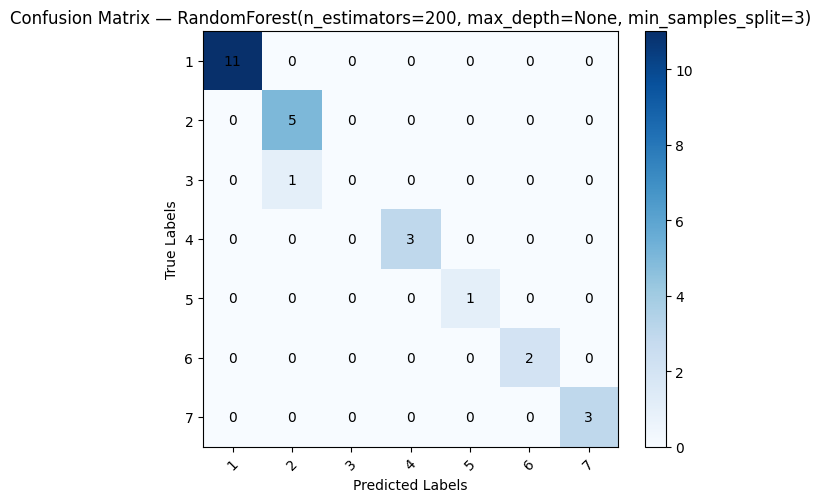

In [39]:
# === Confusion Matrix Heatmap ===
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, test_pred)
classes = sorted(y_test.unique())

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap='Blues')
plt.colorbar()

# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], ha='center', va='center', color='black')

plt.xticks(np.arange(len(classes)), classes, rotation=45)
plt.yticks(np.arange(len(classes)), classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix — RandomForest(n_estimators=200, max_depth=None, min_samples_split=3)")

plt.tight_layout()
plt.show()


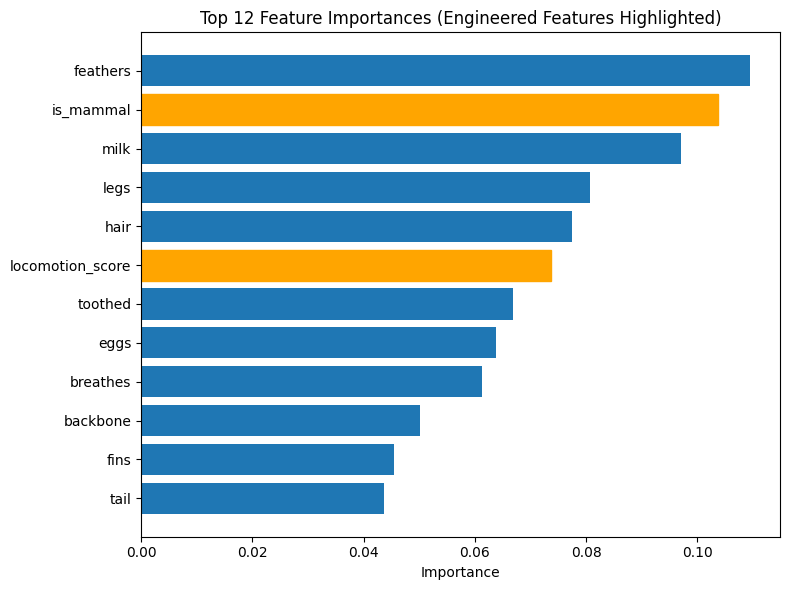

In [40]:
# ===  Feature Importance (Top 12) ===
import pandas as pd
import matplotlib.pyplot as plt

model = data['rf_model']

importances = model.feature_importances_
feature_names = X_train.columns

# put in dataframe
fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

top12 = fi.head(12)

plt.figure(figsize=(8,6))
bars = plt.barh(top12['feature'], top12['importance'])
plt.gca().invert_yaxis()

# highlight engineered features
for i, f in enumerate(top12['feature']):
    if f in ['is_mammal', 'locomotion_score']:
        bars[i].set_color('orange')  # highlight engineered features

plt.xlabel("Importance")
plt.title("Top 12 Feature Importances (Engineered Features Highlighted)")
plt.tight_layout()
plt.show()


In [41]:
# ===  Train Comparison Model — KNN (k = 5) ===
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create model
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train
knn_model.fit(X_train, y_train)

# Predict
knn_train_pred = knn_model.predict(X_train)
knn_test_pred  = knn_model.predict(X_test)

# Accuracy
knn_train_acc = accuracy_score(y_train, knn_train_pred)
knn_test_acc  = accuracy_score(y_test, knn_test_pred)

# Print results
print("=== KNN MODEL (k = 5) ===")
print(f"Training Accuracy: {knn_train_acc:.4f}")
print(f"Testing Accuracy : {knn_test_acc:.4f}")
print(f"Overfitting Gap  : {knn_train_acc - knn_test_acc:.4f}")

# Save for optional later tasks
data['knn_model'] = knn_model


=== KNN MODEL (k = 5) ===
Training Accuracy: 0.8533
Testing Accuracy : 0.7692
Overfitting Gap  : 0.0841


In [42]:
# ===  Critical Analysis Output ===

import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

rf_model = data['rf_model']
knn_model = data['knn_model']

# --- Random Forest feature importance ---
rf_importances = pd.Series(
    rf_model.feature_importances_, index=X_train.columns
).sort_values(ascending=False)

most_important_feature = rf_importances.index[0]

# engineered feature importance
engineered_features = ['is_mammal', 'locomotion_score']
engineered_importance = {
    feat: rf_importances.get(feat, 0) for feat in engineered_features
}

# --- Classification report for RF (to find best/worst class) ---
rf_pred = rf_model.predict(X_test)
report = classification_report(y_test, rf_pred, output_dict=True)

# find best & worst performing classes based on F1-score
class_f1_scores = {
    cls: vals['f1-score']
    for cls, vals in report.items()
    if cls not in ['accuracy', 'macro avg', 'weighted avg']
}

worst_class = min(class_f1_scores, key=class_f1_scores.get)
best_class = max(class_f1_scores, key=class_f1_scores.get)

# --- Model comparison ---
rf_acc = accuracy_score(y_test, rf_pred)
knn_pred = knn_model.predict(X_test)
knn_acc = accuracy_score(y_test, knn_pred)


print("\n===== MODEL ANALYSIS =====\n")

print(f"1. MOST IMPORTANT FEATURE (Random Forest): {most_important_feature}")

print(f"\n2. WORST PERFORMING CLASS (lowest F1-score): {worst_class}")
print(f"   BEST PERFORMING CLASS  (highest F1-score): {best_class}")

print("\n3. ENGINEERED FEATURE IMPORTANCE:")
for feat, imp in engineered_importance.items():
    print(f"   {feat}: {imp:.4f}")

print("\n4. MODEL COMPARISON (Accuracy):")
print(f"   Random Forest Accuracy: {rf_acc:.4f}")
print(f"   KNN (k=5) Accuracy    : {knn_acc:.4f}")

if rf_acc > knn_acc:
    print("   → Random Forest performs better.")
elif knn_acc > rf_acc:
    print("   → KNN performs better.")
else:
    print("   → Both models perform equally.")



===== MODEL ANALYSIS =====

1. MOST IMPORTANT FEATURE (Random Forest): feathers

2. WORST PERFORMING CLASS (lowest F1-score): 3
   BEST PERFORMING CLASS  (highest F1-score): 1

3. ENGINEERED FEATURE IMPORTANCE:
   is_mammal: 0.1036
   locomotion_score: 0.0736

4. MODEL COMPARISON (Accuracy):
   Random Forest Accuracy: 0.9615
   KNN (k=5) Accuracy    : 0.7692
   → Random Forest performs better.


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


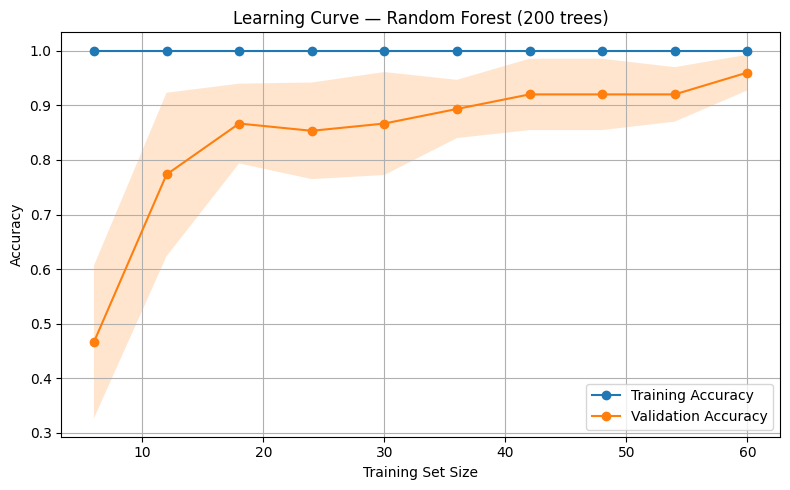

In [43]:
# === BONUS: Learning Curve Plot (Training vs Validation Accuracy) ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

rf_model = data['rf_model']   # your trained Random Forest

# Compute learning curve
train_sizes, train_scores, val_scores = learning_curve(
    rf_model,
    X_train, y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=123
)

# Mean and std
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

# Plot
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Training Accuracy")
plt.plot(train_sizes, val_mean, 'o-', label="Validation Accuracy")

# Fill uncertainty
plt.fill_between(train_sizes, train_mean-train_std,
                 train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std,
                 val_mean+val_std, alpha=0.2)

plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.title("Learning Curve — Random Forest (200 trees)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# === BONUS: 5-Fold Cross Validation (Mean ± Std Accuracy) ===
from sklearn.model_selection import cross_val_score

rf_model = data['rf_model']   # your trained Random Forest

# Perform 5-fold CV on the entire training set
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

print("=== 5-Fold Cross Validation ===")
print("Fold accuracies:", cv_scores)
print(f"Mean accuracy: {cv_scores.mean():.4f}")
print(f"Std deviation: {cv_scores.std():.4f}")
print(f"Mean ± Std: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


=== 5-Fold Cross Validation ===
Fold accuracies: [1.         0.93333333 0.93333333 1.         1.        ]
Mean accuracy: 0.9733
Std deviation: 0.0327
Mean ± Std: 0.9733 ± 0.0327
